## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [1]:
import pandas as pd

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate,GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly,\
                                            NormalPredictor, KNNBasic
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import surprise
from surprise.prediction_algorithms import *
from surprise import Dataset, Reader, accuracy
from surprise import SVD
from surprise import dataset

from surprise.model_selection import cross_validate,GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly,\
                                            NormalPredictor, KNNBasic
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier

    
import matplotlib.pyplot as plt
import seaborn as sns
# from pandas_profiling import ProfileReport
from collections import defaultdict

#from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, make_scorer, ConfusionMatrixDisplay, confusion_matrix

## EDA


In [3]:
link_df = pd.read_csv('data/links.csv')
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')
tags_df = pd.read_csv('data/tags.csv')

In [4]:
link_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


### Data Cleaning

In [8]:
movies_df.title.duplicated().sum()

5

In [9]:
movies_df.drop_duplicates(subset='title', inplace=True)
movies_df.title.duplicated().sum()

0

In [10]:
movies_df[['title', 'year']] = movies_df.title.str.split('(', n=1, expand=True)
movies_df['year'] = movies_df.year.str.replace(')', '')
movies_df

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017
9738,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017
9739,193585,Flint,Drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018


In [11]:
ratings_df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [12]:
ratings_df.duplicated().sum()

0

In [13]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [14]:
#Convert Tags user and movie ID to string so they can be added together
tags_df['userId'] = tags_df['userId'].apply(str)
tags_df['movieId'] = tags_df['movieId'].apply(str)
#Create a new column so user tags for the same movie can be combined togeter
tags_df['userId_movieId'] = tags_df['userId'] + tags_df['movieId']
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userId          3683 non-null   object
 1   movieId         3683 non-null   object
 2   tag             3683 non-null   object
 3   timestamp       3683 non-null   int64 
 4   userId_movieId  3683 non-null   object
dtypes: int64(1), object(4)
memory usage: 144.0+ KB


In [15]:
tags_df['userId_movieId'].duplicated().sum()

1908

In [16]:
#Create a function that combines alll the tags for the same movie and user together
f = {c: ' '.join if c == 'tag' else 'first' for c in ['userId', 'movieId', 'timestamp', 'tag']}

tags_df = tags_df.groupby(
    tags_df.userId_movieId.astype(str), sort=False
).agg(f).reset_index().eval(
    'userId_movieId = @pd.to_numeric(userId_movieId, "coerce").values',
    inplace=False
)

In [17]:
tags_df['userId'] = tags_df['userId'].apply(int)
tags_df['movieId'] = tags_df['movieId'].apply(int)
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1775 entries, 0 to 1774
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userId_movieId  1775 non-null   int64 
 1   userId          1775 non-null   int64 
 2   movieId         1775 non-null   int64 
 3   timestamp       1775 non-null   int64 
 4   tag             1775 non-null   object
dtypes: int64(4), object(1)
memory usage: 69.5+ KB


In [18]:
tags_df

,userId_movieId,userId,movieId,timestamp,tag
0,260756,2,60756,1445714994,funny Highly quotable will ferrell
1,289774,2,89774,1445715207,Boxing story MMA Tom Hardy
2,2106782,2,106782,1445715054,drugs Leonardo DiCaprio Martin Scorsese
3,748516,7,48516,1169687325,way too long
4,18431,18,431,1462138765,Al Pacino gangster mafia
...,...,...,...,...,...
1770,6066107,606,6107,1178473747,World War II
1771,6067382,606,7382,1171234019,for katie
1772,6067936,606,7936,1173392334,austere
1773,6103265,610,3265,1493843984,gun fu heroic bloodshed


### Merge Dataframes Together
We want to make sure that the number of rows stays the same throughout

In [19]:
ratings_movie_df = ratings_df.merge(movies_df, on  = 'movieId')
ratings_movie_df

,userId,movieId,rating,timestamp,title,genres,year
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,5,1,4.0,847434962,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
2,7,1,4.5,1106635946,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
3,15,1,2.5,1510577970,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
4,17,1,4.5,1305696483,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
...,...,...,...,...,...,...,...
100825,610,160341,2.5,1479545749,Bloodmoon,Action|Thriller,1997
100826,610,160527,4.5,1479544998,Sympathy for the Underdog,Action|Crime|Drama,1971
100827,610,160836,3.0,1493844794,Hazard,Action|Drama|Thriller,2005
100828,610,163937,3.5,1493848789,Blair Witch,Horror|Thriller,2016


In [20]:
ratings_movie_tags_df = ratings_movie_df.merge(tags_df, 
                                               left_on = ['movieId', 'userId'], 
                                               right_on = ['movieId', 'userId'], 
                                               how = 'left')
ratings_movie_tags_df

,userId,movieId,rating,timestamp_x,title,genres,year,userId_movieId,timestamp_y,tag
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN
1,5,1,4.0,847434962,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN
2,7,1,4.5,1106635946,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN
3,15,1,2.5,1510577970,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN
4,17,1,4.5,1305696483,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
100825,610,160341,2.5,1479545749,Bloodmoon,Action|Thriller,1997,NaN,NaN,NaN
100826,610,160527,4.5,1479544998,Sympathy for the Underdog,Action|Crime|Drama,1971,NaN,NaN,NaN
100827,610,160836,3.0,1493844794,Hazard,Action|Drama|Thriller,2005,NaN,NaN,NaN
100828,610,163937,3.5,1493848789,Blair Witch,Horror|Thriller,2016,NaN,NaN,NaN


In [21]:
df_complete = ratings_movie_tags_df.merge(link_df,  how = 'left', on = 'movieId')
df_complete

,userId,movieId,rating,timestamp_x,title,genres,year,userId_movieId,timestamp_y,tag,imdbId,tmdbId
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0
1,5,1,4.0,847434962,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0
2,7,1,4.5,1106635946,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0
3,15,1,2.5,1510577970,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0
4,17,1,4.5,1305696483,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0
...,...,...,...,...,...,...,...,...,...,...,...,...
100825,610,160341,2.5,1479545749,Bloodmoon,Action|Thriller,1997,NaN,NaN,NaN,118745,30948.0
100826,610,160527,4.5,1479544998,Sympathy for the Underdog,Action|Crime|Drama,1971,NaN,NaN,NaN,66806,90351.0
100827,610,160836,3.0,1493844794,Hazard,Action|Drama|Thriller,2005,NaN,NaN,NaN,798722,70193.0
100828,610,163937,3.5,1493848789,Blair Witch,Horror|Thriller,2016,NaN,NaN,NaN,1540011,351211.0


### Exploratory Graphs

In [22]:
years = []

for year in df_complete['year']:
    year_subset = year
    try: years.append(int(year_subset))
    except: years.append(9999)
        
df_complete['moviePubYear'] = years
print(len(df_complete[df_complete['moviePubYear'] == 9999]))

6798


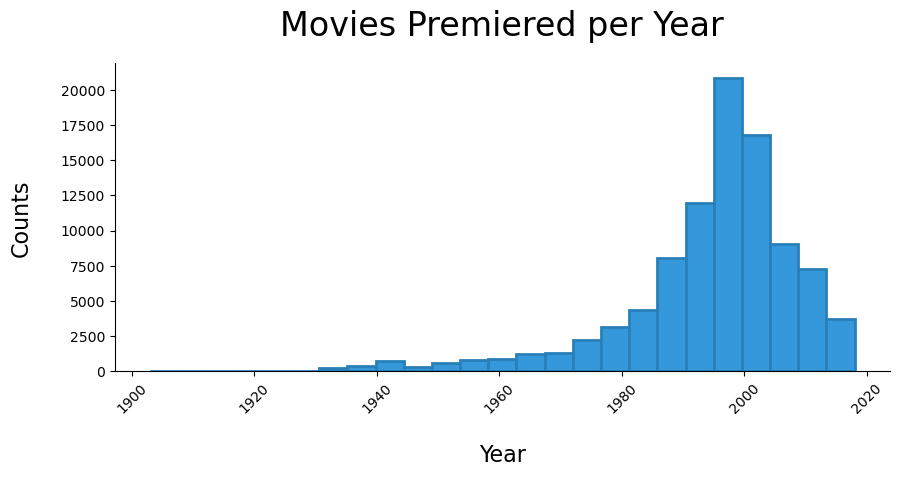

In [23]:
def make_histogram(df, attribute, bins=25, bar_color='#3498db', edge_color='#2980b9', title='title', xlab='X', ylab='Y', sort_index=False):
    if attribute == 'moviePubYear':
        df = df[df['moviePubYear'] != 9999]
        
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.hist(df[attribute], bins=bins, color=bar_color, ec=edge_color, linewidth=2)
    
    plt.xticks(rotation=45)
    
    
make_histogram(df_complete, 'moviePubYear', title='Movies Premiered per Year', xlab='Year', ylab='Counts')

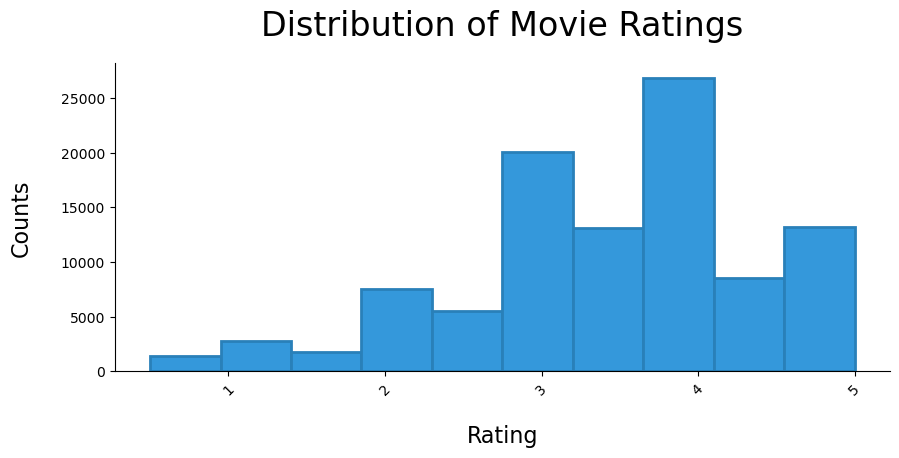

In [24]:
make_histogram(df_complete,'rating', bins = 10, title='Distribution of Movie Ratings', xlab='Rating', ylab='Counts')
plt.xticks(rotation=45);

In [25]:
# Split Genres to Graph
genre_df = pd.DataFrame(df_complete['genres'].str.split('|').tolist(), index=df_complete['movieId']).stack()
genre_df = genre_df.reset_index([0, 'movieId'])
genre_df.columns = ['movieId', 'Genre']
genre_df.head()

,movieId,Genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


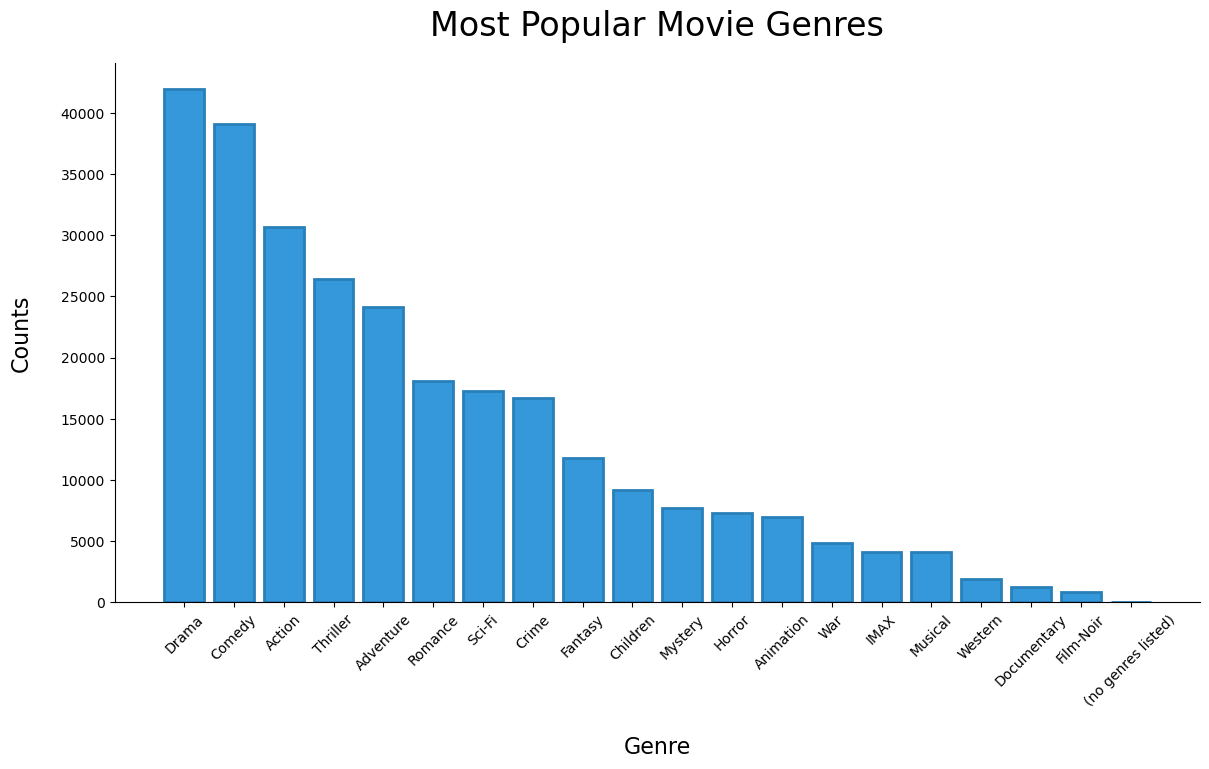

In [26]:
def make_bar_chart(df, attribute, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False):
    if sort_index == False:
        xs = df[attribute].value_counts().index
        ys = df[attribute].value_counts().values
    else:
        xs = df[attribute].value_counts().sort_index().index
        ys = df[attribute].value_counts().sort_index().values
        
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.bar(x=xs, height=ys, color=bar_color, edgecolor=edge_color, linewidth=2)
    plt.xticks(rotation=45)
    
    
make_bar_chart(genre_df, 'Genre', title='Most Popular Movie Genres', xlab='Genre', ylab='Counts')

In [27]:
#Graph the number of ratings per movie
num_ratings = pd.DataFrame(df_complete.groupby('movieId').count()['rating']).reset_index()
df_complete = pd.merge(left=df_complete, right=num_ratings, on='movieId')
df_complete.rename(columns={'rating_x': 'rating', 'rating_y': 'numRatings'}, inplace=True)

In [28]:
df_complete.sort_values(by='numRatings', ascending=False).drop_duplicates('movieId')

,userId,movieId,rating,timestamp_x,title,genres,year,userId_movieId,timestamp_y,tag,imdbId,tmdbId,moviePubYear,numRatings
2562,251,356,5.0,1470677298,Forrest Gump,Comedy|Drama|Romance|War,1994,NaN,NaN,NaN,109830,13.0,1994,329
16425,250,318,5.0,1121217814,"Shawshank Redemption, The",Crime|Drama,1994,NaN,NaN,NaN,111161,278.0,1994,317
1897,145,296,4.0,832105148,Pulp Fiction,Comedy|Crime|Drama|Thriller,1994,NaN,NaN,NaN,110912,680.0,1994,307
4491,404,593,4.0,838375784,"Silence of the Lambs, The",Crime|Horror|Thriller,1991,NaN,NaN,NaN,102926,274.0,1991,279
12678,77,2571,5.0,1535107478,"Matrix, The",Action|Sci-Fi|Thriller,1999,NaN,NaN,NaN,133093,603.0,1999,278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97656,387,3680,3.0,1148942975,Decline of Western Civilization Part II: The M...,Documentary,1988,NaN,NaN,NaN,94980,36724.0,1988,1
97662,387,3838,2.0,1126494985,Phantasm III: Lord of the Dead,Horror,1994,NaN,NaN,NaN,110823,16139.0,1994,1
93717,217,2056,3.0,955942449,In Search of the Castaways,Adventure|Children,1962,NaN,NaN,NaN,56095,34774.0,1962,1
97667,387,3919,2.5,1129960571,Hellraiser III: Hell on Earth,Horror,1992,NaN,NaN,NaN,104409,11569.0,1992,1


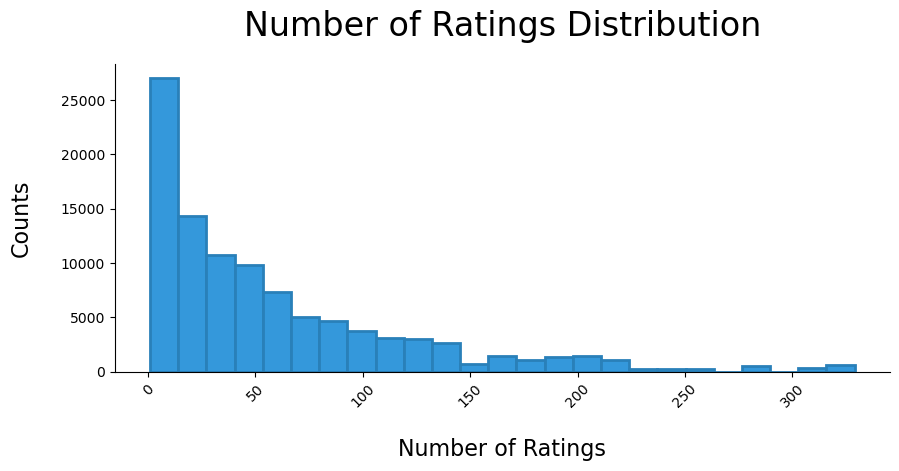

In [29]:
make_histogram(df_complete,'numRatings', bins = 25, title='Number of Ratings Distribution', xlab='Number of Ratings', ylab='Counts')
plt.xticks(rotation=45);

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [30]:
df = df_complete

In [31]:
matrix = df.pivot_table(
    index='userId',
    columns='title',
    values='rating'
)

In [32]:
matrix

title,,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,*batteries not included,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


In [33]:
def get_similar_movies(movie_title, n_ratings_filter=100, n_recommendations=10):
    similar = matrix.corrwith(matrix[movie_title])
    corr_similar = pd.DataFrame(similar, columns=['correlation'])
    corr_similar.dropna(inplace=True)
    
    orig = df.copy()
    
    corr_with_movie = pd.merge(
        left=corr_similar, 
        right=orig, 
        on='title')[['title', 'correlation', 'numRatings']].drop_duplicates().reset_index(drop=True)
    
    result = corr_with_movie[corr_with_movie['numRatings'] > n_ratings_filter].sort_values(by='correlation', ascending=False)
    
    return result.head(n_recommendations)

In [34]:
get_similar_movies('Pulp Fiction ')

/Users/julietday/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/julietday/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,title,correlation,numRatings
3571,Pulp Fiction,1.000000,307
1540,Fight Club,0.543465,218
2444,Kill Bill: Vol. 1,0.504147,131
4602,Trainspotting,0.437714,102
2445,Kill Bill: Vol. 2,0.421685,110
4717,"Usual Suspects, The",0.411700,204
194,Amelie,0.402193,120
1423,Eternal Sunshine of the Spotless Mind,0.401534,131
3684,Reservoir Dogs,0.394687,131
4653,Twelve Monkeys,0.391141,177


### Train Test Split

In [35]:
data = df[['userId', 'movieId', 'rating']]
data

,userId,movieId,rating
0,1,1,4.0
1,5,1,4.0
2,7,1,4.5
3,15,1,2.5
4,17,1,4.5
...,...,...,...
100825,610,160341,2.5
100826,610,160527,4.5
100827,610,160836,3.0
100828,610,163937,3.5


### Convert Pandas Dataframe to Suprise Data format

In [36]:
# Create a dummy reader
reader = Reader(line_format='user item rating', rating_scale=(1, 5))

# Create, a dummy Dataset class
class MyDataset(dataset.DatasetAutoFolds):

    def __init__(self, df, reader):

        self.raw_ratings = [(uid, iid, r, None) for (uid, iid, r) in
                            zip(df['userId'], df['movieId'], df['rating'])]
        self.reader=reader

data = MyDataset(df, reader)

In [37]:
train, test = surprise.model_selection.train_test_split(data, random_state=42)

In [38]:
model = KNNBasic().fit(train)
#Singular Value Decomposition
model2 = SVD().fit(train)
#Non-Negative Matrix Factorization
model3 = NMF().fit(train)


Computing the msd similarity matrix...
Done computing similarity matrix.


In [39]:
model.get_neighbors(iid=51, k=1)

[89]

In [40]:
conds = [df['movieId'] == 1, df['movieId'] == 65]
choices = 2*[True]

df.loc[np.select(conds, choices, default=False)].sort_values('userId')

,userId,movieId,rating,timestamp_x,title,genres,year,userId_movieId,timestamp_y,tag,imdbId,tmdbId,moviePubYear,numRatings
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0,1995,215
1,5,1,4.0,847434962,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0,1995,215
28161,6,65,3.0,845555070,Bio-Dome,Comedy,1996,NaN,NaN,NaN,115683,9536.0,1996,31
2,7,1,4.5,1106635946,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0,1995,215
3,15,1,2.5,1510577970,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0,1995,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,607,1,4.0,964744033,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0,1995,215
28191,608,65,2.0,1117415653,Bio-Dome,Comedy,1996,NaN,NaN,NaN,115683,9536.0,1996,31
212,608,1,2.5,1117408267,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0,1995,215
213,609,1,3.0,847221025,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0,1995,215


## Evaluation and Model Selection

In [41]:
#Some models are taking too long to run in one cell. SVDpp and Slopeone won't run on my computer
#benchmark = []
# Iterate over all algorithms
#for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(),
 #KNNWithMeans(), KNNWithZScore(), BaselineOnly()]:
 # Perform cross validation
 #results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
 
 # Get results & append algorithm name
 #tmp = pd.DataFrame.from_dict(results).mean(axis=0)
 #tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split(' ')[-1]], index=['Algorithm']))
 #benchmark.append(tmp)

In [42]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBaseline(), KNNBasic(), BaselineOnly()]:
 # Perform cross validation
 results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
 
 # Get results & append algorithm name
 tmp = pd.DataFrame.from_dict(results).mean(axis=0)
 tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split(' ')[-1]], index=['Algorithm']))
 benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [43]:
benchmark

[test_rmse                                             0.879988
 fit_time                                               3.31512
 test_time                                             0.200617
 Algorithm    <surprise.prediction_algorithms.matrix_factori...
 dtype: object,
 test_rmse                                             0.932398
 fit_time                                               3.49999
 test_time                                             0.115775
 Algorithm    <surprise.prediction_algorithms.matrix_factori...
 dtype: object,
 test_rmse                                            0.883143
 fit_time                                              0.11339
 test_time                                             1.90446
 Algorithm    <surprise.prediction_algorithms.knns.KNNBaseline
 dtype: object,
 test_rmse                                         0.956144
 fit_time                                         0.0400634
 test_time                                          1.44328
 Algorit

In [44]:
benchmark2 = []
# Iterate over all algorithms
for algorithm in [KNNWithMeans(), KNNWithZScore()]:
 # Perform cross validation
 results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
 
 # Get results & append algorithm name
 tmp2 = pd.DataFrame.from_dict(results).mean(axis=0)
 tmp2 = tmp.append(pd.Series([str(algorithm).split(' ')[0].split(' ')[-1]], index=['Algorithm']))
 benchmark2.append(tmp)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [45]:
benchmark2

[test_rmse                                              0.87709
 fit_time                                             0.0951244
 test_time                                              0.12048
 Algorithm    <surprise.prediction_algorithms.baseline_only....
 dtype: object,
 test_rmse                                              0.87709
 fit_time                                             0.0951244
 test_time                                              0.12048
 Algorithm    <surprise.prediction_algorithms.baseline_only....
 dtype: object]

In [46]:
trainSet = data.build_full_trainset()

algo = NormalPredictor()

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4197  1.4269  1.4228  1.4206  1.4198  1.4220  0.0027  
MAE (testset)     1.1345  1.1401  1.1355  1.1359  1.1338  1.1360  0.0022  
Fit time          0.07    0.08    0.08    0.08    0.08    0.08    0.00    
Test time         0.15    0.08    0.15    0.08    0.15    0.12    0.03    


{'test_rmse': array([1.41973636, 1.42689817, 1.42284617, 1.42055137, 1.41976065]),
 'test_mae': array([1.13454804, 1.14005941, 1.13554146, 1.13590158, 1.13380789]),
 'fit_time': (0.07306504249572754,
  0.08118295669555664,
  0.08185291290283203,
  0.08101296424865723,
  0.08439922332763672),
 'test_time': (0.15277099609375,
  0.08171319961547852,
  0.14897990226745605,
  0.08366084098815918,
  0.15106678009033203)}

In [47]:
model.test(test)

[Prediction(uid=212, iid=81834, r_ui=4.0, est=3.963940492254296, details={'actual_k': 36, 'was_impossible': False}),
 Prediction(uid=249, iid=40815, r_ui=3.5, est=3.761796505469874, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=32, iid=1393, r_ui=4.0, est=3.6656222756903563, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=33, iid=1653, r_ui=5.0, est=3.933277627239878, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=42, iid=3717, r_ui=4.0, est=3.269134132591516, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=121, iid=539, r_ui=4.0, est=3.3348316071049906, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=483, iid=88163, r_ui=4.0, est=4.020981503393646, details={'actual_k': 25, 'was_impossible': False}),
 Prediction(uid=474, iid=1243, r_ui=4.0, est=3.8553884958748825, details={'actual_k': 12, 'was_impossible': False}),
 Prediction(uid=219, iid=40819, r_ui=2.0, est=3.8759310366910817, deta

In [48]:
surprise.accuracy.mae(model.test(test))

MAE:  0.7285


0.7285083677085515

In [49]:
surprise.accuracy.mae(model2.test(test))

MAE:  0.6761


0.676107293706945

In [50]:
surprise.accuracy.mae(model3.test(test))

MAE:  0.7132


0.7131708047642108

In [51]:
surprise.accuracy.rmse(model.test(test))

RMSE: 0.9532


0.9531736880144391

In [52]:
surprise.accuracy.rmse(model2.test(test))

RMSE: 0.8835


0.8835497935859786

In [53]:
surprise.accuracy.rmse(model3.test(test))

RMSE: 0.9328


0.9328059450370766

## How it works for a particular user

In [54]:
# user_id is the 100
ratings = df.loc[df['userId'] == 100]
# obtain the required data of this user
ratings=ratings[['userId', 'movieId', 'title', 'year' ]]
ratings

,userId,movieId,title,year
227,100,3,Grumpier Old Men,1995
1277,100,223,Clerks,1994
1510,100,235,Ed Wood,1994
1868,100,296,Pulp Fiction,1994
2482,100,356,Forrest Gump,1994
...,...,...,...,...
87807,100,2262,About Last Night...,1986
87816,100,3244,"Goodbye Girl, The",1977
87828,100,5380,"Importance of Being Earnest, The",2002
87838,100,6183,Pillow Talk,1959


In [55]:
# get the list of the movie ids
unique_ids = df['movieId'].unique()
# get the list of the ids that the userid 100 has watched
iids1001 = df.loc[df['userId']==100, 'movieId']
# remove the rated movies for the recommendations
movies_to_predict = np.setdiff1d(unique_ids,iids1001)

In [56]:
#Best model based off of crossvalidation
algo = BaselineOnly()
algo.fit(train)
my_recs = []
for iid in movies_to_predict:
 my_recs.append((iid, algo.predict(uid='100',iid=iid).est))
pred_df = pd.DataFrame(my_recs, columns=['iid', 'predictions']).sort_values('predictions', ascending=False) 
rec_df = movies_df.merge(pred_df, right_on="iid", left_on="movieId", how = "right")
rec_df

Estimating biases using als...


,movieId,title,genres,year,iid,predictions
0,318,"Shawshank Redemption, The",Crime|Drama,1994,318,4.415552
1,1196,Star Wars: Episode V - The Empire Strikes Back,Action|Adventure|Sci-Fi,1980,1196,4.315422
2,2959,Fight Club,Action|Crime|Drama|Thriller,1999,2959,4.290665
3,1204,Lawrence of Arabia,Adventure|Drama|War,1962,1204,4.288214
4,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,1964,750,4.288093
...,...,...,...,...,...,...
9566,1562,Batman & Robin,Action|Adventure|Fantasy|Thriller,1997,1562,2.625372
9567,2701,Wild Wild West,Action|Comedy|Sci-Fi|Western,1999,2701,2.604246
9568,8666,Catwoman,Action|Crime|Fantasy,2004,8666,2.603471
9569,1882,Godzilla,Action|Sci-Fi|Thriller,1998,1882,2.568371


In [57]:
rec_df = rec_df.drop(["iid"], axis = 1)

In [58]:
rec_df.head()

,movieId,title,genres,year,predictions
0,318,"Shawshank Redemption, The",Crime|Drama,1994,4.415552
1,1196,Star Wars: Episode V - The Empire Strikes Back,Action|Adventure|Sci-Fi,1980,4.315422
2,2959,Fight Club,Action|Crime|Drama|Thriller,1999,4.290665
3,1204,Lawrence of Arabia,Adventure|Drama|War,1962,4.288214
4,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,1964,4.288093


In [59]:
df[df['movieId'] == 318]

,userId,movieId,rating,timestamp_x,title,genres,year,userId_movieId,timestamp_y,tag,imdbId,tmdbId,moviePubYear,numRatings
16296,2,318,3.0,1445714835,"Shawshank Redemption, The",Crime|Drama,1994,NaN,NaN,NaN,111161,278.0,1994,317
16297,5,318,3.0,847434880,"Shawshank Redemption, The",Crime|Drama,1994,NaN,NaN,NaN,111161,278.0,1994,317
16298,6,318,5.0,845553200,"Shawshank Redemption, The",Crime|Drama,1994,NaN,NaN,NaN,111161,278.0,1994,317
16299,8,318,5.0,839463489,"Shawshank Redemption, The",Crime|Drama,1994,NaN,NaN,NaN,111161,278.0,1994,317
16300,11,318,4.0,902155070,"Shawshank Redemption, The",Crime|Drama,1994,NaN,NaN,NaN,111161,278.0,1994,317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16608,606,318,3.5,1171927228,"Shawshank Redemption, The",Crime|Drama,1994,NaN,NaN,NaN,111161,278.0,1994,317
16609,607,318,5.0,963080679,"Shawshank Redemption, The",Crime|Drama,1994,NaN,NaN,NaN,111161,278.0,1994,317
16610,608,318,4.5,1147210910,"Shawshank Redemption, The",Crime|Drama,1994,NaN,NaN,NaN,111161,278.0,1994,317
16611,609,318,4.0,847220907,"Shawshank Redemption, The",Crime|Drama,1994,NaN,NaN,NaN,111161,278.0,1994,317
